In [2]:
# 데이터셋 반영
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('../../dataset/processed/hair_salon_data.csv')
df.head()

,ID,book_tod,book_dow,book_category,book_staff,last_category,last_staff,last_day_services,last_receipt_tot,last_dow,...,last_cumbook,last_cumstyle,last_cumcolor,last_cumprod,last_cumcancel,last_cumnoshow,noshow,recency,first_visit,is_revisit_30days
0,0,afternoon,Wednesday,STYLE,JJ,Unknown,Unknown,0,0.0,Unknown,...,0,0,0,0,0,0,0,0,1,1
1,1,morning,Wednesday,COLOR,JOANNE,Unknown,Unknown,0,0.0,Unknown,...,0,0,0,0,0,0,0,0,1,1
2,2,afternoon,Wednesday,STYLE,JJ,COLOR,JOANNE,2,262.0,Wednesday,...,2,1,1,2,0,0,0,35,0,0
3,3,afternoon,Thursday,STYLE,KELLY,Unknown,Unknown,0,0.0,Unknown,...,0,0,0,0,0,0,0,0,1,1
4,4,evening,Saturday,STYLE,KELLY,STYLE,KELLY,1,35.0,Thursday,...,1,1,0,0,0,0,0,9,0,1


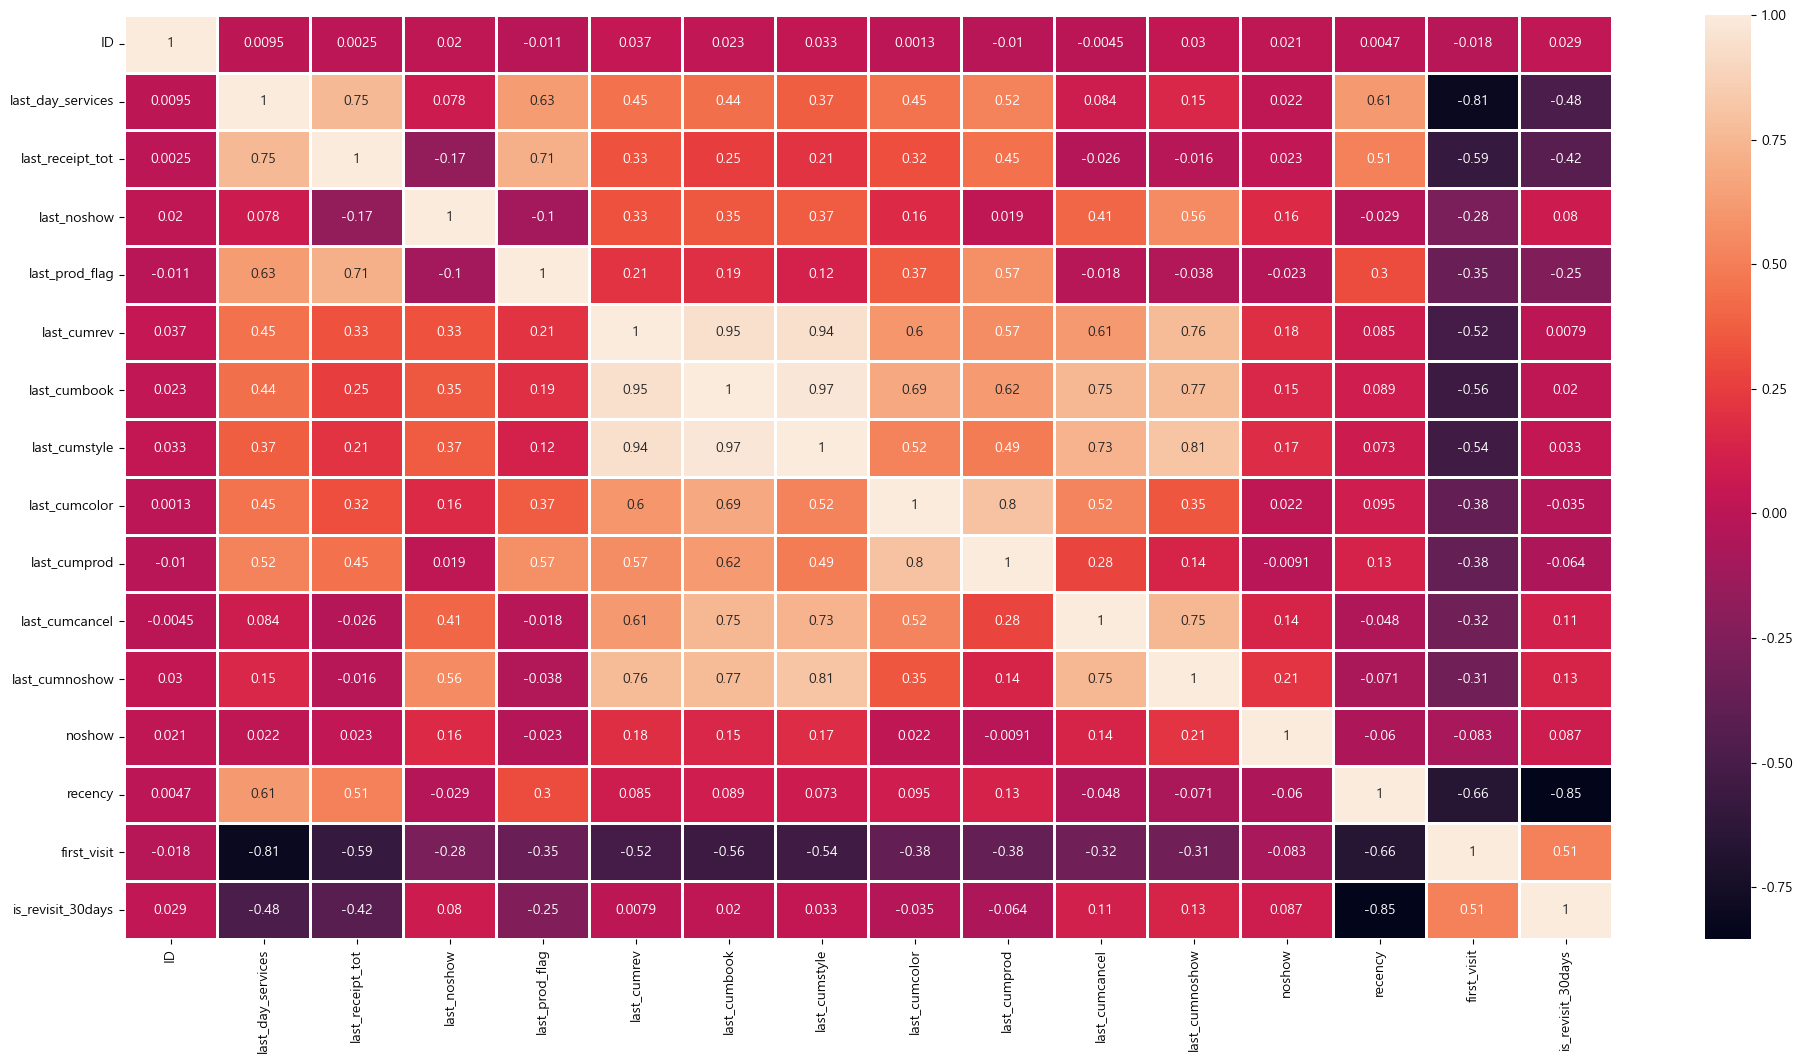

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns

num_col = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize = (24, 12))

corr = num_col.corr()
sns.heatmap(corr, annot = True, linewidths = 1)
plt.show()

In [5]:
X = df.drop(columns='noshow')
y = df['noshow']

categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

categorical_idx = [X.columns.get_loc(col) for col in categorical_cols]
numeric_idx = [X.columns.get_loc(col) for col in numeric_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_idx),
        ('num', StandardScaler(), numeric_idx)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression(random_state=0))
])

param_grid = {
    'classifier__penalty': ['l2'],  # 또는 ['l1', 'l2'] (solver에 따라 제한됨)
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'lbfgs'],  # 'l1'은 'liblinear', 'saga'만 지원
    'classifier__class_weight': ['balanced', None],
    'classifier__max_iter': [100, 200, 500]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1', # 평가 기준
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         [1, 2,
                                                                          3, 4,
                                                                          5, 6,
                                                                          9,
                                                                          10]),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         [0, 7,
                                                                          8, 11,
                                                                          12,
                                                                          13,
                                                                          14,
                                                                          15,
                                                                          16,
                                                                          17,
                                                                          18,
                                                                          19,
                                                                          20,
                                                                          21,
                                                                          22])])),
                                       ('classifier',
                                        LogisticRegression(random_state=0))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__class_weight': ['balanced', None],
                         'classifier__max_iter': [100, 200, 500],
                         'classifier__penalty': ['l2'],
                         'classifier__solver': ['liblinear', 'lbfgs']},
             scoring='f1', verbose=1)

In [6]:
from metrics import print_binary_classification_metrics

pred_train = grid_search.predict(X_train)
pred_train_proba = grid_search.predict_proba(X_train)[:, 1]
print_binary_classification_metrics(y_train, pred_train, pred_train_proba)

pred_test = grid_search.predict(X_test)
pred_test_proba = grid_search.predict_proba(X_test)[:, 1]
print_binary_classification_metrics(y_test, pred_test, pred_test_proba)

정확도: 0.7623318385650224
재현율: 0.6193181818181818
정밀도: 0.2639225181598063
F1 점수: 0.3701188455008489
Average Precision: 0.29077704678088273
ROC-AUC Score: 0.7840662947161142
정확도: 0.7468030690537084
재현율: 0.5833333333333334
정밀도: 0.2616822429906542
F1 점수: 0.36129032258064514
Average Precision: 0.3057914481409053
ROC-AUC Score: 0.7651239067055393


Fitting 5 folds for each of 60 candidates, totalling 300 fits
📌 최적 threshold: 0.50
🔍 Recall: 0.5833
🔍 Precision: 0.2617
🔍 F1 Score: 0.3613
🔢 Confusion Matrix:
[[264  79]
 [ 20  28]]


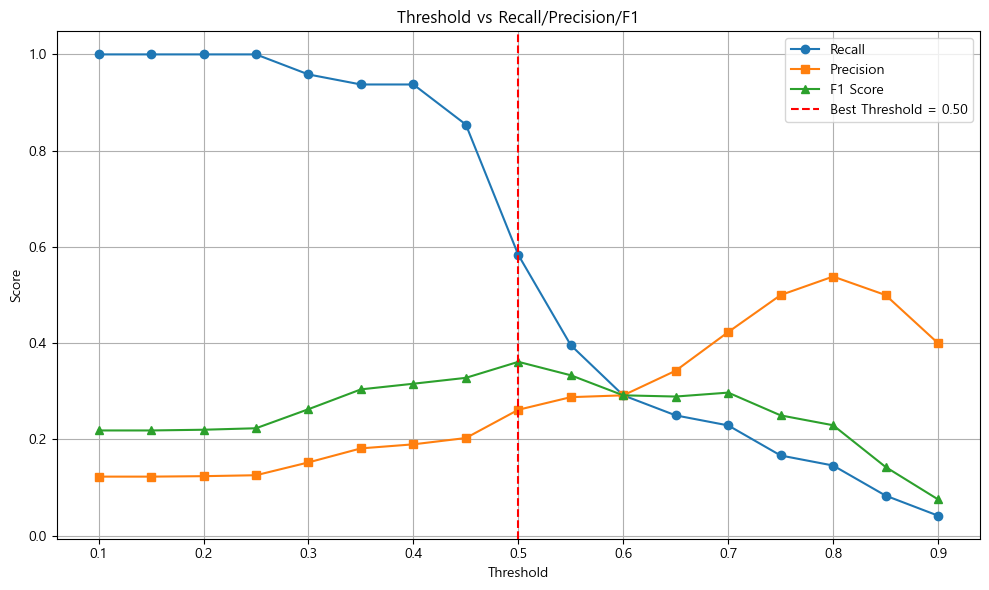

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    f1_score, confusion_matrix
)
import numpy as np
import matplotlib.pyplot as plt

# 1. GridSearchCV 실행 (이미 하셨음)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# 2. 테스트 데이터 확률 예측
y_proba = best_model.predict_proba(X_test)[:, 1]

# 3. 여러 임계값에서 지표 측정
thresholds = np.arange(0.1, 0.91, 0.05)
recalls, precisions, f1s, accuracies = [], [], [], []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    
    recalls.append(recall_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    accuracies.append(accuracy_score(y_test, y_pred))

# 4. 최적 임계값 (F1 기준)
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]

print(f"📌 최적 threshold: {best_threshold:.2f}")
print(f"🔍 Recall: {recalls[best_idx]:.4f}")
print(f"🔍 Precision: {precisions[best_idx]:.4f}")
print(f"🔍 F1 Score: {f1s[best_idx]:.4f}")

# 5. confusion matrix 출력
y_final = (y_proba >= best_threshold).astype(int)
print("🔢 Confusion Matrix:")
print(confusion_matrix(y_test, y_final))

# 6. 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recalls, label="Recall", marker='o')
plt.plot(thresholds, precisions, label="Precision", marker='s')
plt.plot(thresholds, f1s, label="F1 Score", marker='^')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Recall/Precision/F1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

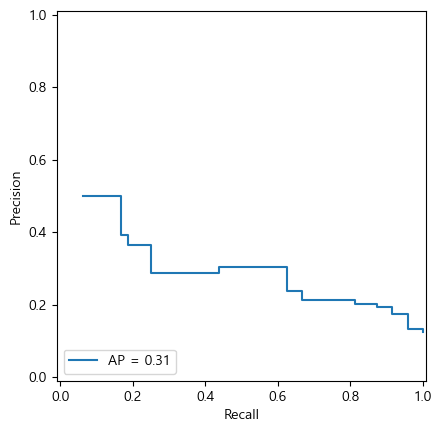

In [22]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score

lr_ap = average_precision_score(y_test, y_proba)
disp = PrecisionRecallDisplay(
    precisions,
    recalls,
    average_precision=lr_ap
)
disp.plot()